In [2]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
(X_Train,_),(_,_) = mnist.load_data()

In [4]:
print(X_Train.shape)

(60000, 28, 28)


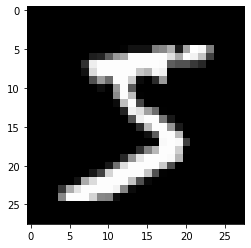

In [6]:
plt.imshow(X_Train[0],cmap='gray')
plt.show()

In [8]:
# NOrmalize this data [-1,1]
X_Train = (X_Train.astype('float32')-127.5)/127.5
print("Min. value in X_Train",np.min(X_Train))
print("Max. value in X_Train",np.max(X_Train))

print(X_Train.shape)

Min. value in X_Train -1.0078431
Max. value in X_Train -0.99215686
(60000, 28, 28)


In [12]:
# Constants
total_epochs = 50
batch_size = 256
no_of_batches = int(X_Train.shape[0]/batch_size)
half_batch = 128 
Noise_dim = 100 # upsample into 784 dim_vector
adam = Adam(lr=2e-4,beta_1=0.5)


In [13]:
# Generator
generator = Sequential()
generator.add(Dense(256,input_shape=(Noise_dim,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))

generator.compile(loss='binar_crossentropy',optimizer=adam)
generator.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)              

In [26]:
# discriminator 
discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


#### GAN -->

In [27]:
# GAN [ STEP _ 2 ]
discriminator.trainable = False
gan_input = Input(shape=(Noise_dim,)) # Acts as a placeholder
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)


In [28]:
X_Train = X_Train.reshape((-1,784))
X_Train.shape

(60000, 784)

In [34]:
def save_imgs(epochs,samples=100):
    noise = np.random.normal(0,1,size=(samples,Noise_dim))
    generated_imgs = generator.predict(noise)
    generator_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],inteplotation='nearest',cmap='grey')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('images/gan_output_epochs_{0}.png'.format(epochs+1))
    plt.show()

In [31]:
# Training Time !! -->
# training is a two step process -->
for epoch in range(total_epochs):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    # Mini Batch SGD
    for step in range(no_of_batches):
        
        # Step - 1 Discriminator
        # 50% real data + 50% fake data
        
        # real data
        idx = np.random.randint(0,X_Train.shape[0],half_batch)
        real_imgs = X_Train[idx]
        # fake data
        noise = np.random.normal(0,1,size=(half_batch,Noise_dim))
        fake_imgs = generator.predict(noise)  # Forward # No training so far
        
        # Labels
        real_y = np.ones((half_batch,1))*0.9 # One sided label smoothing for discriminators
        fake_y = np.zeros((half_batch,1))
        
        # Train our discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
        d_loss = 0.5*(d_loss_fake+d_loss_real)
        
        epoch_d_loss += d_loss
        
        # Train the generator (considering frozen discriminator)
        noise = np.random.normal(0,1,size=(batch_size,Noise_dim))
        ground_truth_y = np.ones((batch_size,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)  # model --> the whole model
        epoch_g_loss += g_loss
    print('Epoch %d Discriminator loss %.4f Generator loss %.4f'%((epoch+1),epoch_d_loss/no_of_batches,epoch_g_loss/no_of_batches))
    
    if (epoch+1)%5 == 0:
        generator.save('model/gen_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)
        

Epoch 1 Discriminator loss 0.7072 Generator loss 0.8234
Epoch 2 Discriminator loss 0.7060 Generator loss 0.8213
Epoch 3 Discriminator loss 0.7010 Generator loss 0.8166
Epoch 4 Discriminator loss 0.7061 Generator loss 0.8207
Epoch 5 Discriminator loss 0.6971 Generator loss 0.8107
Epoch 6 Discriminator loss 0.7044 Generator loss 0.8179
Epoch 7 Discriminator loss 0.7004 Generator loss 0.8116
Epoch 8 Discriminator loss 0.7012 Generator loss 0.8132
Epoch 9 Discriminator loss 0.6965 Generator loss 0.8057
Epoch 10 Discriminator loss 0.7024 Generator loss 0.8128
Epoch 11 Discriminator loss 0.7154 Generator loss 0.8161
Epoch 12 Discriminator loss 0.6953 Generator loss 0.7955
Epoch 13 Discriminator loss 0.6993 Generator loss 0.8050
Epoch 14 Discriminator loss 0.7034 Generator loss 0.8055
Epoch 15 Discriminator loss 0.6921 Generator loss 0.7906
Epoch 16 Discriminator loss 0.7042 Generator loss 0.8027
Epoch 17 Discriminator loss 0.6951 Generator loss 0.7996
Epoch 18 Discriminator loss 0.6968 Gener

In [33]:
# !mkdir images

In [ ]:
# !zip -r /content/images.zip /content/images 

In [ ]:
# from google.colab import files
# files.download('images.zip')

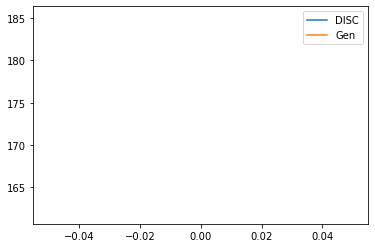

In [41]:
plt.plot(epoch_d_loss,label='DISC')
plt.plot(epoch_g_loss,label='Gen')
plt.legend()
plt.show()